In [1]:
import jax 
import jax.numpy as jnp

x0 = [0.1, 0.1]
y = [1.8, 0.2]
T = 3.0
N = 500

In [2]:
import src.models
from src.training import train_utils
import orbax.checkpoint


def mean_and_std(trajs):
    mean = jnp.mean(trajs, axis=0)
    std = jnp.std(trajs, axis=0)
    return mean, std


def plot_mean_and_std(mean, std, ts, ax, fig, axs):
    axs.plot(ts, mean[:, ax])
    axs.fill_between(ts, mean[:, ax] - std[:, ax], mean[:, ax] + std[:, ax], alpha=0.5)
    return fig, axs


def load_checkpoint(checkpoint_path):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = src.models.score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    trained_score = train_utils.trained_score(model, params)
    return trained_score


Load unconditioned trajectories

In [3]:
from src.data_generate_sde import sde_cell_model

fw_N = 500
data_fn  = sde_cell_model.data_forward(x0, T, fw_N)
keys = jax.random.split(jax.random.PRNGKey(10), 1000)

ts_mult, forward_trajs, _ = data_fn(keys)
ts = ts_mult[0, :, 0]



Load conditioned trajectories from proposed model

In [4]:
from src.data_generate_sde import sde_cell_model
from src.data_generate_sde import sde_utils
import functools


path = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/cell/fixed_y_{y}_T_{T}_N_600"

ts_cond = jnp.linspace(0, T, N)

trained_score = load_checkpoint(path)

def conditioned_fn(key):
    drift, diffusion = sde_cell_model.vector_fields()
    traj = sde_utils.conditioned(key, ts_cond, x0, trained_score, drift, diffusion)
    return traj


keys = jax.random.split(jax.random.PRNGKey(20), 1000)
conditioned_trajs = jax.vmap(conditioned_fn)(keys)

Load time reversed trajectories from diffusion bridge

In [5]:
import numpy as np

diffusion_bridge_fw = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/cell_traj_T_3.0_X0_tensor([0.1000, 0.1000])_XT_tensor([1.8000, 0.2000])_M_600_100.npy")

time_steps = diffusion_bridge_fw.shape[1]
ts_fw = np.linspace(0, T, time_steps)

Load trajectories from guided MH

In [6]:
import pandas as pd
import jax.numpy as jnp
import numpy as np

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/Users/libbybaker/Documents/Bridge.jl/example/cell_model_runs/cell_T_3_x_0.1_y_[1.8, 0.2].csv')

iterations = []
for i in range(1000):
    iteration = df[df['iteration'] == i]
    vals = iteration['value'].values
    vals = np.reshape(vals, (-1, 2))
    iterations.append(vals)
    
guided_traj = jnp.asarray(iterations)
time_steps = guided_traj.shape[1]
ts_gt = np.linspace(0, T, time_steps)

Plot everything

In [7]:
import matplotlib.pyplot as plt
from tueplots import bundles, axes, cycler, figsizes
from tueplots.constants.color import palettes

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))
plt.rcParams.update(axes.lines())


def plot_trajectories(trajs, ts, axis, axs, color, **plot_kwargs):
    for traj in trajs:
        axs.plot(ts, traj[:, axis], color=color, **plot_kwargs)
    return axs

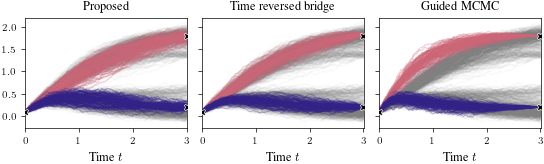

In [14]:
plt.rcParams.update(figsizes.neurips2023(nrows=1, ncols=2))

fig, axs = plt.subplot_mosaic([["proposed", "forward", "guided"]], sharex=True, sharey=True)

upper_max = 2.3
upper_min = 1.3
lower_max = 0.7
lower_min = -1.0

plot_kwargs_true = {"linewidth": 0.8, "alpha": 0.05}
plot_kwargs = {"linewidth": 0.8, "alpha": 0.3}

for ax in axs["proposed"], axs["guided"], axs["forward"]:
    
    for traj in forward_trajs:
        if traj[-1, 0] > upper_min and lower_min < traj[-1, 1] < lower_max:
            ax.plot(ts, traj[:, 0], color='grey', **plot_kwargs_true)
            ax.plot(ts, traj[:, 1], color='grey', **plot_kwargs_true)
        if traj[-1, 1] > upper_min and lower_min < traj[-1, 0] < lower_max:
            ax.plot(ts, traj[:, 1], color='grey', **plot_kwargs_true)
            ax.plot(ts, traj[:, 0], color='grey', **plot_kwargs_true)
            
    ax.set_xlim(-0.01, 3.01)
    ax.set_xlabel("Time $t$")
    ax.plot([0, 3, 3], [0.1, 1.8, 0.2], marker="X",markersize=5, markeredgewidth=0.5, linestyle="None", zorder=10, color="black", markeredgecolor="white")
  
axs["guided"] = plot_trajectories(guided_traj[:100], ts_gt, 0, axs["guided"], 'C0', **plot_kwargs)
axs["guided"] = plot_trajectories(guided_traj[:100], ts_gt, 1, axs["guided"], 'C1', **plot_kwargs)
axs["guided"].set_title("Guided MCMC")


axs["forward"] = plot_trajectories(diffusion_bridge_fw[:100], ts_fw, 0, axs["forward"], 'C0', **plot_kwargs)
axs["forward"] = plot_trajectories(diffusion_bridge_fw[:100], ts_fw, 1, axs["forward"], 'C1', **plot_kwargs)
axs["forward"].set_title("Time reversed bridge")


axs["proposed"] = plot_trajectories(conditioned_trajs[:100], ts_cond, 0, axs["proposed"], 'C0', **plot_kwargs)
axs["proposed"] = plot_trajectories(conditioned_trajs[:100], ts_cond, 1, axs["proposed"], 'C1', **plot_kwargs)
axs["proposed"].set_title("Proposed")


plt.savefig("messy_plot.pdf")
# fig, axs = plot_trajectories(diffusion_bridge_fw, ts_gt, 0, fig, axs, 'C2', alpha=0.5)

In [9]:
assert False

AssertionError: 

In [ ]:
from src.plotting import plot_score_2d

plot_score_2d(learned_score=trained_score)

In [ ]:
checkpoint_path_forward = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/cell/forward/fixed_x0_{x0}"

restored_f = orbax_checkpointer.restore(checkpoint_path_forward)
model_f = src.models.score_mlp.ScoreMLP(**restored_f["network"])
params_f = restored_f["params"]
trained_score_forward= utils.trained_score(model_f, params_f)

In [ ]:
from src.data_generate_sde import utils as sde_utils
from src.data_generate_sde import sde_cell_model, time
import functools
import jax
import matplotlib.pyplot as plt

ts = time.grid(0, T, 400)

drift, diffusion = sde_cell_model.vector_fields()
bw_fn = functools.partial(sde_utils.backward, ts=ts, y=y, score_fn=trained_score_forward, drift=drift, diffusion=diffusion)

keys = jax.random.split(jax.random.PRNGKey(0), 100)

conditioned_trajs = jax.vmap(bw_fn)(keys)

for traj in conditioned_trajs:
    plt.plot(ts, traj[:, 0])
plt.show()

for traj in conditioned_trajs:
    plt.plot(ts, traj[:, 1])
plt.show()

In [ ]:
from src.plotting import plot_score_2d

plot_score_2d(learned_score=trained_score_forward)

In [ ]:
import src.models

import orbax.checkpoint
from src.training import utils
from src.data_generate_sde import time

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

x0 = [0.1, 0.1]
y = [2.0, 0.3]
T = 2.0
ts = time.grid(0, T, 400)


checkpoint_path_23 = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/cell/fixed_y_{y}_T_{T}"
restored_23 = orbax_checkpointer.restore(checkpoint_path_23)
model_23 = src.models.score_mlp.ScoreMLP(**restored_23["network"])
params_23 = restored_23["params"]
trained_score_23 = utils.trained_score(model_23, params_23)
sde_23 = restored_23["sde"]
print(sde_23)

In [ ]:
from src.data_generate_sde import utils as sde_utils
from src.data_generate_sde import sde_cell_model, time
import functools
import jax
import matplotlib.pyplot as plt

drift, diffusion = sde_cell_model.vector_fields()
conditioned_fn = functools.partial(sde_utils.conditioned, ts=ts, x0=x0, score_fn=trained_score_23, drift=drift, diffusion=diffusion)

keys = jax.random.split(jax.random.PRNGKey(0), 100)

conditioned_trajs = jax.vmap(conditioned_fn)(keys)

for traj in conditioned_trajs:
    plt.plot(ts, traj[:, 0])
plt.show()

for traj in conditioned_trajs:
    plt.plot(ts, traj[:, 1])
plt.show()

In [ ]:
import src.models

import orbax.checkpoint
from src.training import utils
from src.data_generate_sde import time

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

x0 = [0.1, 0.1]
y = [2.0, 0.3]
T = 4.0
ts = time.grid(0, T, 400)


checkpoint_path_T4 = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/cell/fixed_y_{y}_T_{T}"
restored_T4 = orbax_checkpointer.restore(checkpoint_path_T4)
model_T4 = src.models.score_mlp.ScoreMLP(**restored_T4["network"])
params_T4 = restored_T4["params"]
trained_score_T4 = utils.trained_score(model_T4, params_T4)
sde_T4 = restored_T4["sde"]
print(sde_T4)

In [ ]:
from src.data_generate_sde import utils as sde_utils
from src.data_generate_sde import sde_cell_model, time
import functools
import jax
import matplotlib.pyplot as plt

drift, diffusion = sde_cell_model.vector_fields()
conditioned_fn = functools.partial(sde_utils.conditioned, ts=ts, x0=x0, score_fn=trained_score_T4, drift=drift, diffusion=diffusion)

keys = jax.random.split(jax.random.PRNGKey(0), 100)

conditioned_trajs = jax.vmap(conditioned_fn)(keys)

for traj in conditioned_trajs:
    plt.plot(ts, traj[:, 0])
plt.show()

for traj in conditioned_trajs:
    plt.plot(ts, traj[:, 1])
plt.show()

In [ ]:
import src.models

import orbax.checkpoint
from src.training import utils
from src.data_generate_sde import time

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

x0 = [0.1, 0.1]
y = [2.0, 0.3]
T = 30.0
ts = time.grid(0, T, 400)


# checkpoint_path_guided = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/cell/fixed_x0_{x0}_y_{y}"

checkpoint_path_guided = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/cell/fixed_y_{y}_T_{T}_forward_data"

restored_guided = orbax_checkpointer.restore(checkpoint_path_guided)
model_guided = src.models.score_mlp.ScoreMLP(**restored_guided["network"])
params_guided = restored_guided["params"]
trained_score_guided = utils.trained_score(model_guided, params_guided)
sde_guided = restored_guided["sde"]
print(sde_guided)

In [ ]:
from src.data_generate_sde import utils as sde_utils
from src.data_generate_sde import sde_cell_model, time
import functools
import jax
import matplotlib.pyplot as plt

drift, diffusion = sde_cell_model.vector_fields()
conditioned_fn = functools.partial(sde_utils.conditioned, ts=ts, x0=x0, score_fn=trained_score_guided, drift=drift, diffusion=diffusion)

keys = jax.random.split(jax.random.PRNGKey(0), 100)

conditioned_trajs = jax.vmap(conditioned_fn)(keys)

for traj in conditioned_trajs:
    plt.plot(ts, traj[:, 0])
plt.show()

for traj in conditioned_trajs:
    plt.plot(ts, traj[:, 1])
plt.show()